# Time Series and Forecasting Models: SARIMA

## 1. Introduction

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model combines simpler models in order to capture moving averages throughout time series, taking into account trend, seasonality, and noise. 

We will build, train and test a SARIMA model for predicting AstraZeneca Adjusted Close price patterns.



## 2. Install/import libraries

In [ ]:
!pip install mplfinance
!pip install pmdarima

In [ ]:
!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf

from scipy import stats
from scipy.stats import zscore

from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product
from tqdm.notebook import tqdm

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [2]:
nifty_stocks = yf.download("RELIANCE.NS  BPCL.NS HINDPETRO.NS TECHM.NS INFY.NS WIPRO.NS HINDUNILVR.NS BRITANNIA.NS NESTLEIND.NS BAJAJ-AUTO.NS MARUTI.NS EICHERMOT.NS   AXISBANK.NS ICICIBANK.NS HDFCBANK.NS", start=datetime.datetime(2011, 4, 1), 
                                      end=datetime.datetime(2023, 3, 31), group_by='tickers')

nifty_stocks.head()

[*********************100%***********************]  15 of 15 completed


HINDUNILVR.NS                                                   
                    Open        High         Low       Close   Adj Close   
Date                                                                       
2011-04-01    286.000000  290.049988  282.000000  283.950012  228.572723  \
2011-04-04    283.100006  284.899994  277.149994  279.649994  225.111282   
2011-04-05    279.000000  282.750000  274.000000  275.350006  221.649902   
2011-04-06    276.000000  278.200012  274.100006  277.200012  223.139114   
2011-04-07    277.600006  279.250000  275.000000  276.000000  222.173187   

                    BAJAJ-AUTO.NS                                         ...   
             Volume          Open         High          Low        Close  ...   
Date                                                                      ...   
2011-04-01  1301124   1478.000000  1481.900024  1448.050049  1458.949951  ...  \
2011-04-04   970446   1472.000000  1474.400024  1440.000000  1456.949951  ...   
2011-04-05  1201569   1458.699951  1458.699951  1433.750000  1438.150024  ...   
2011-04-06  1355991   1440.000000  1465.000000  1435.949951  1451.599976  ...   
2011-04-07  1185709   1459.949951  1459.949951  1436.000000  1440.250000  ...   

           RELIANCE.NS                                  HINDPETRO.NS   
                   Low       Close   Adj Close   Volume         Open   
Date                                                                   
2011-04-01  510.659454  513.334106  468.434601  8663538    78.344444  \
2011-04-04  509.668854  520.392212  474.875458  6051061    77.677780   
2011-04-05  515.117188  518.906311  473.519440  4964260    78.011108   
2011-04-06  515.117188  517.519409  472.253876  4191928    78.000000   
2011-04-07  512.690186  516.058289  470.920532  4690528    78.677780   

                                                                 
                 High        Low      Close  Adj Close   Volume  
Date                                                             
2011-04-01  78.644447  77.111115  78.300003  41.286419  1106221  
2011-04-04  78.800003  77.422218  77.988892  41.122379  1403901  
2011-04-05  78.288887  76.555557  77.666664  40.952484  2833704  
2011-04-06  80.444443  77.777779  78.511108  41.397739  3294198  
2011-04-07  82.377777  78.666664  81.500000  42.973736  5989504  

[5 rows x 90 columns]

In [3]:
# Create DataFrame of AZN.L stock data

RI =  nifty_stocks['RELIANCE.NS']
                                     
RI.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,519.599731,527.945618,510.659454,513.334106,468.434601,8663538
2011-04-04,515.117188,522.447693,509.668854,520.392212,474.875458,6051061
2011-04-05,521.308533,524.528015,515.117188,518.906311,473.519440,4964260
2011-04-06,517.593750,522.175293,515.117188,517.519409,472.253876,4191928
2011-04-07,517.618469,518.856750,512.690186,516.058289,470.920532,4690528


In [4]:
# Create DataFrame for Adjusted Close prices

RI_adj = RI[['Adj Close']]
RI_adj

,Adj Close
Date,
2011-04-01,468.434601
2011-04-04,474.875458
2011-04-05,473.519440
2011-04-06,472.253876
2011-04-07,470.920532
...,...
2023-03-23,2247.800049
2023-03-24,2203.300049
2023-03-27,2237.550049


In [5]:
# Plot Adjusted Close price

def RI_adj_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  RI_adj.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

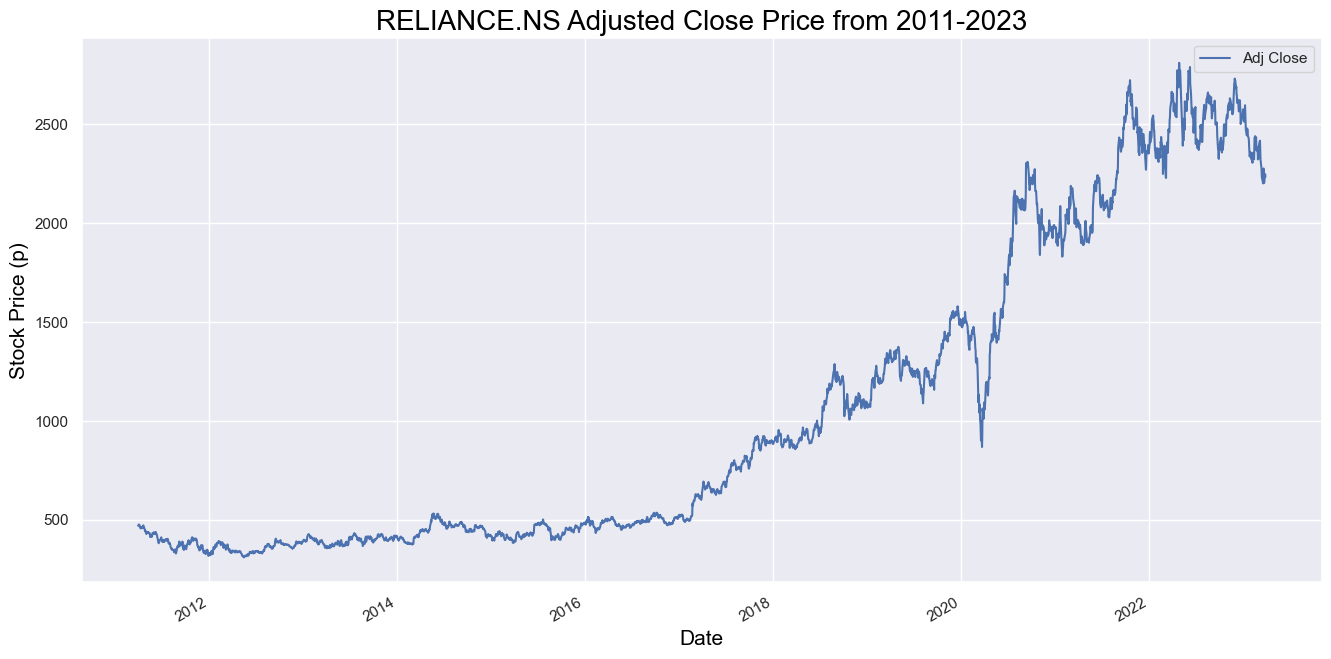

In [6]:
title_txt = "RELIANCE.NS Adjusted Close Price from 2011-2023"
label_txt = "RELIANCE.NS Adj Close"

RI_adj_plot()

In [7]:
#  Create DataFrame of Adjusted Close prices from the last 1000 periods

RI_adj_1000 = RI_adj[-1000:]

In [8]:
# Plot last 1000 periods

def RI_adj_1000_plot():
  sns.set(rc={'figure.figsize':(16, 8)})
  RI_adj_1000.plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

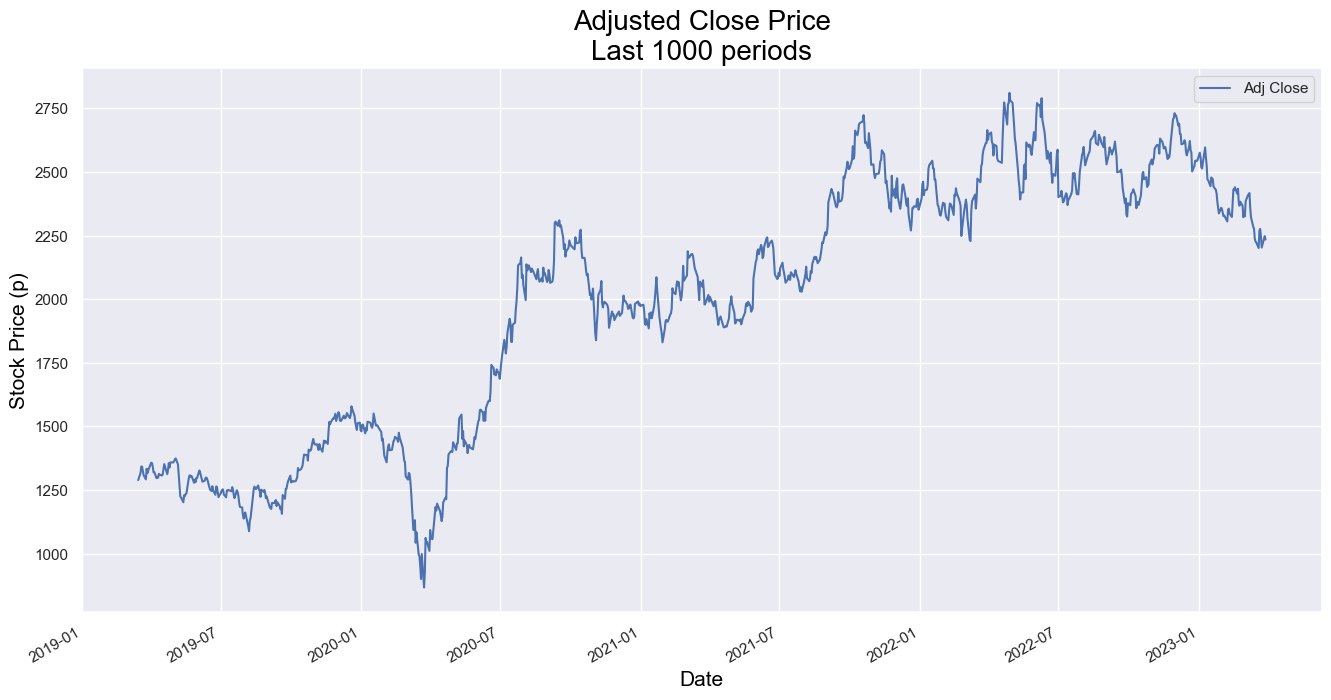

In [9]:
title_txt = "Adjusted Close Price\nLast 1000 periods"
label_txt = "RELIANCE.NS Adj Close"

RI_adj_1000_plot()

## 4. Stationarity

Before modelling with SARIMA we must apply transformations to our time series to remove seasonality and any non-stationary behaviours.

### 4.1 Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

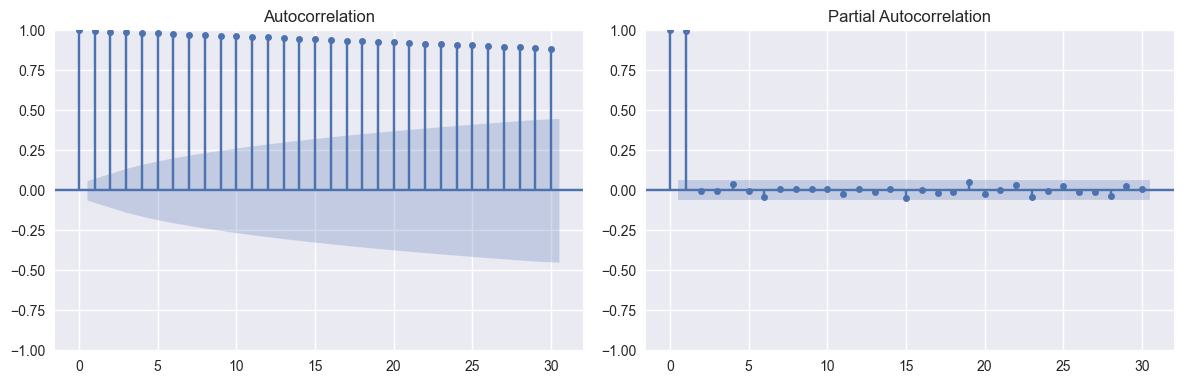

In [10]:
# ACF and PACF for original non-differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(RI_adj_1000, lags=30)

There is clearly high autocorrelation. We will run an ADF test to further test for stationarity.

### 4.2 Augmented Dickey-Fuller (ADF) test

In [11]:
# Check if price series is stationary
# Augmented Dickey-Fuller test

result = adfuller(RI_adj_1000.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.559103129832521
p-value: 0.5040979848128337


The p-value is greater than the significance level of 0.05 so we cannot reject the null hypothesis that the process is not stationary. The next step is to determine the order of differencing required to make the series stationary.


### 4.3 Differencing

In [12]:
# Detrend by first order differencing to achieve lower p-value

result = adfuller(RI_adj_1000.diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -31.125462852244304
p-value: 0.0


The p-value is now much less than the significance level of 0.05 so the null hypothesis is rejected, and the process is considered to be stationary.

In [13]:
# Create DataFrame of differenced prices

RI_adj_1000_diff = RI_adj_1000.diff().dropna()

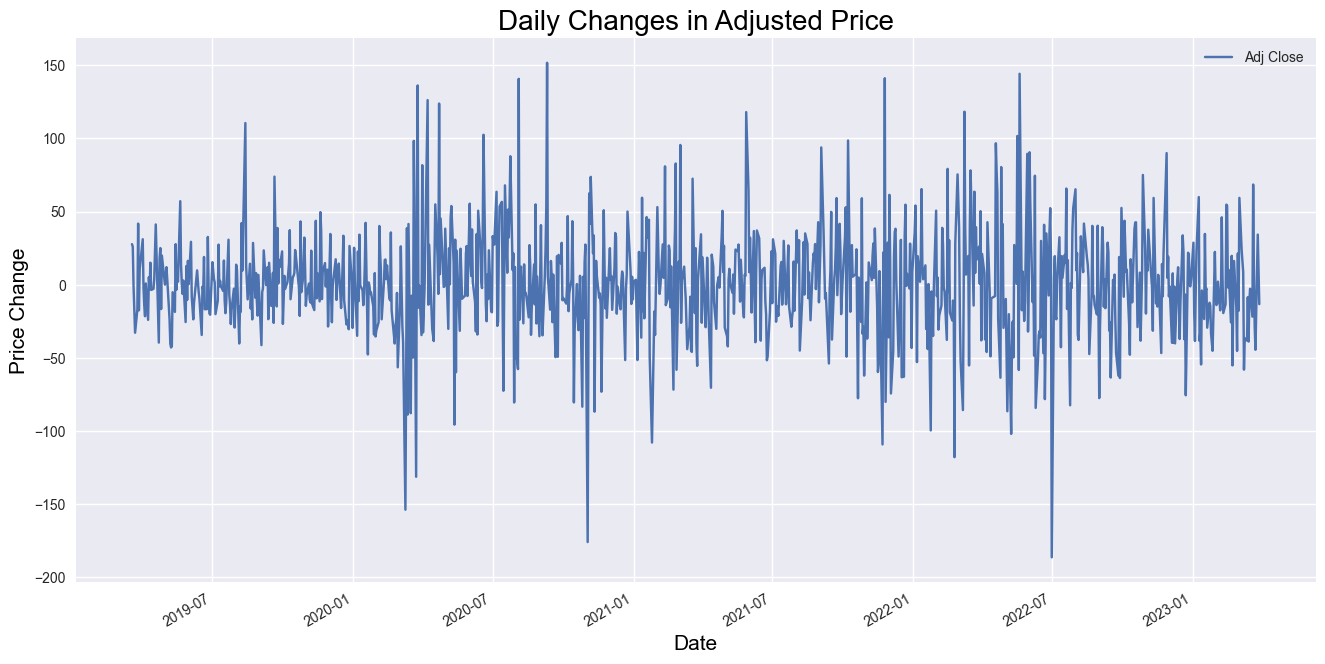

In [14]:
# Plot returns

def returns_plot():
  plt.style.use('seaborn')
  RI_adj_1000_diff.plot(figsize=(16,8))
  plt.title("Daily Changes in Adjusted Price", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price Change', color = 'black', fontsize = 15);
  plt.show()

returns_plot()

We can see that the returns randomly distribute around the mean of 0.

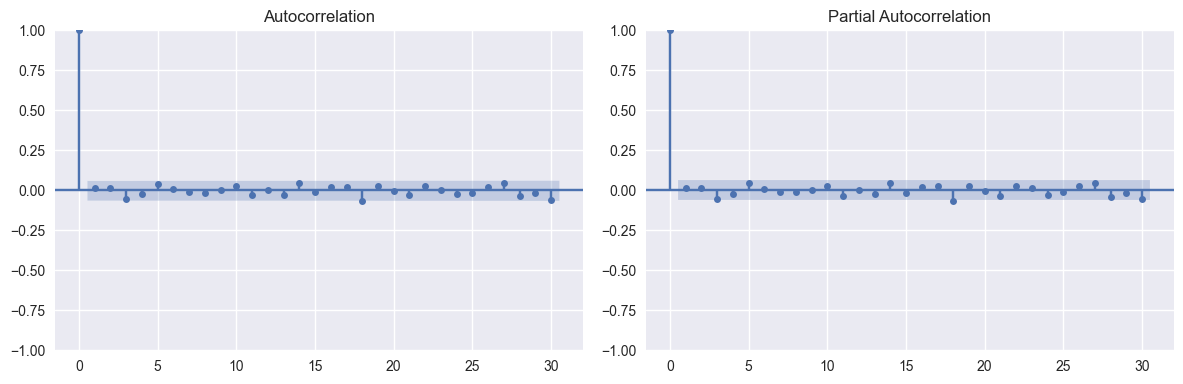

In [15]:
# ACF and PACF for the differenced data

def acf_pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
acf_pacf_plot(RI_adj_1000_diff, lags=30)

The plots above resemble those of white noise, therefore this model is ready to be used for forecasting.

## 5. Select parameters for modelling


A **SARIMA(p, d, q)(P, D, Q, s)** model takes the parameters: 
*   **AR(p)** from the Autoregression model representing the maximum lag,
*   **MA(q)** from the Moving Average model representing the biggest lag after which other lags are not significant on the ACF plot
*  The order of **Integration (d)** representing the number of
differences required to make the series stationary
* **Seasonality** in (P, D, Q, s) where **s** is the season's length, **P** and **Q** are the same as **p** and **q** but for the seasonal component, and **D** is the order of seasonal integration representing the number of differences required to remove seasonality from the series. 

A **SARIMAX** implementation is so-called because the **X** addition means that it also supports exogenous variables. This is an optional argument, rather than a parameter, for parallel time series variates made available as a weighted input to the model.

### 5.1 Grid search to select the best order for SARIMA model

In [16]:
# Grid search function to iteratively explore different combinations of parameters

def best_param(model, data, pdq, pdqs):
    """
    Iterates through and runs model for all combinations for pdq and pdqs 
    to find model with lowest AIC score

    :param model: SARIMAX
    :param data: time series data 
    :param pdq: list with (p, d, q) tuples
    :param pdqs: list with (p, d, q, s) tuples 

    :returns: parameters and corresponding lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

### 5.2 Parameters to iterate through

In [17]:
# Set initial values and some bounds for p, d, q.
p = d = q = range(0,5)
d = [1]

# Creating a list of all possible parameter combinations of p, d, q.
pdq = list(product(p, d, q))


# Add seasonal component to (p, d, q)
pdqs = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]


### 5.3 Search for optimum parameters

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install --upgrade notebook

In [ ]:
!pip install ipywidgets widgetsnbextension pandas-profiling

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [18]:
import pandas as pd
df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [1, 2, 3, 4]})

In [19]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_widgets()

ModuleNotFoundError: No module named 'pandas_profiling'

In [20]:
# Finding best parameters for model

best_param(SARIMAX, RI_adj_1000, pdq, pdqs)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

pdq         (0, 1, 4)
pdqs    (2, 1, 4, 12)
aic       9468.102333
Name: 114, dtype: object

## 6. Modelling

### 6.1 Define training and test set

In [ ]:
# Split data into train and test set 

index = round(len(azn_adj_1000)*.80)

train = azn_adj_1000.iloc[:index]
test = azn_adj_1000.iloc[index:]

### 6.2 Fit and train the model

In [ ]:
# Fit best model to training data

model = SARIMAX(train, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

### Output summary of best model

In [ ]:
print(output.summary())

We can see that the best performing model has both seasonal and non-seasonal moving average processes and seasonal autoregressive processes.

### Study the residuals

In [ ]:
# Ljung-Box test and Augmented Dickey-Fuller test 
ljung_box, p_value = acorr_ljungbox(output.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Looking at the p-values above, we can see that they are above 0.05, therefore we cannot reject the null hypothesis, and the residuals are are independent and not correlated.

### Plot residuals

In [ ]:
output.plot_diagnostics(figsize=(15,8))
plt.show()

The correlogram, or ACF plot, shows no autocorrelation in the results as none are over the significance level and are just white noise. The normal Q-Q plot is almost straight suggesting no systematic departure from normality.

### 6.3 Test the model

In [ ]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = pd.Series(fc.predicted_mean.values, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(dynamic=False)
pred        = predictions.predicted_mean

# Confidence interval for the training set
conf_int   = predictions.conf_int()
low_conf   = pd.Series(conf_int.iloc[:,0], index=train.index)
upper_conf = pd.Series(conf_int.iloc[:,1], index=train.index)

### Plot train, test, predicted values and confidence interval

In [ ]:
sns.set(rc={'figure.figsize':(16, 8)})

# Plotting the training set, test set, forecast, and confidence interval.
plt.plot(train[-120:], label='train', color='gold')
plt.plot(test, label='actual', color='b')
plt.plot(fc_series, label='forecast', color='r')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred[-120:].plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int[-90:].index, conf_int[-90:].iloc[:,0], conf_int[-90:].iloc[:,1], color='g',alpha=.5)

plt.title('Fit to Training Data and \nForecast vs Actual Test Values')
plt.legend()
plt.show()

###  6.4 Evaluate the model

In [ ]:
# Calculate the RMSE

forecast = pred
actual_val = train['Adj Close']

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

### 6.5 Predict future values 

In [ ]:
# Fitting and training with the entire dataset 


model = SARIMAX(azn_adj_1000, 
                order=(0, 1, 4), 
                seasonal_order=(2,1,4,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [ ]:
# Getting the forecast of future values
future = output.get_forecast(steps=90)

# Predicted values
pred_fut = pd.Series(future.predicted_mean.values, 
                     index=pd.date_range(start=azn_adj_1000.index[-1]+datetime.timedelta(days=1), periods=90, freq="D"))

# Confidence interval for our forecasted values
pred_conf = pd.DataFrame(future.conf_int().values, 
                      index=pd.date_range(start=azn_adj_1000.index[-1]+datetime.timedelta(days=1), periods=90, freq="D"))

# Saving last daily prediction for later
d90 = pred_fut[-1]

### Plot the predicted values

In [ ]:
# Plotting the prices up to the most recent
ax = azn_adj_1000.plot(label='Actual', figsize=(16,8))

# Plotting the forecast
pred_fut.plot(ax=ax, label='Future Values', color='r')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.xlim(['2019', pred_fut.index[-1]])
plt.title('Forecasted values')
plt.legend()
plt.show()

### Print prediction

In [ ]:
sarimax_preds = pd.DataFrame([d90], index=['day'], columns=['prediction'])
sarimax_preds

The predicted rise in the Adjusted Close price pattern for the first quarter of 2020, however, will be inaccurate due to the Covid-19 stock market crash from 20 February to 7 April.